In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from ai.FeatureAE import FeatureAE
from ai.DataLoader2 import DataLoader
from env import *

ETA = 1e-2
LAMBDA = 1e-1
EPOCHS = 500

print(torch.cuda.is_available())

True


In [2]:
train_dloader = DataLoader(TRASH_TRAIN_DATA_PATH, TRASH_CAT, noise=False)
valid_dloader = DataLoader(TRASH_VALID_DATA_PATH, TRASH_CAT, noise=False)

Number of data batch: 489
Number of batch: 7
Number of data batch: 131
Number of batch: 2


In [3]:
model = FeatureAE()
model = model.cuda()

In [4]:
optimizer = optim.Adam(model.parameters(), lr=ETA)
criterion = nn.NLLLoss()

Original1:


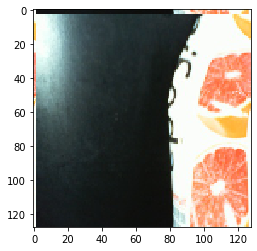

Reconstructed1:


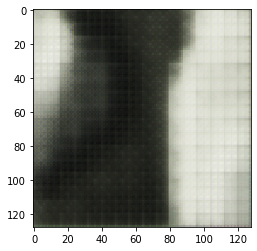

Original2:


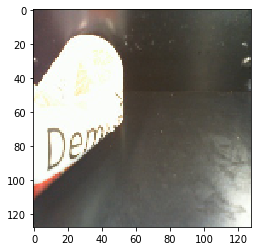

Reconstructed2:


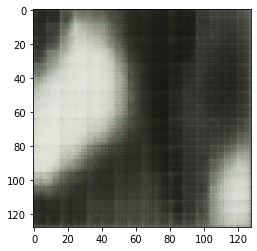

Epochs: 10/500
Train loss: 1.06111455
Train acc: 0.57477677
Valid loss: 2.03591454
Valid acc: 0.27734375
Original1:


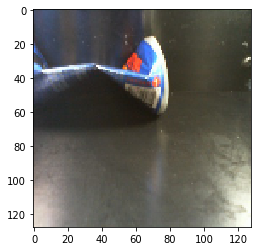

Reconstructed1:


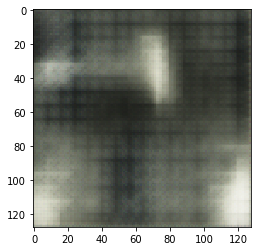

Original2:


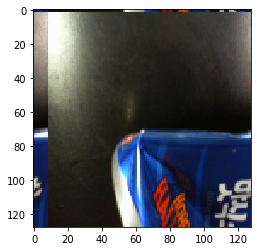

Reconstructed2:


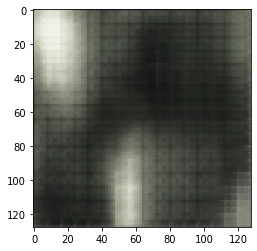

Epochs: 20/500
Train loss: 0.88409337
Train acc: 0.66741073
Valid loss: 2.14453733
Valid acc: 0.29296875
Original1:


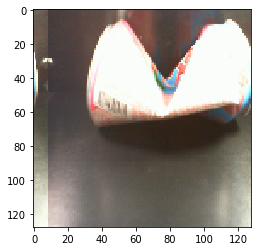

Reconstructed1:


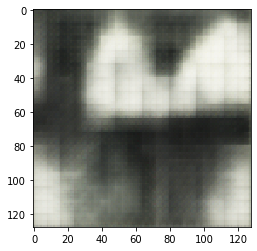

Original2:


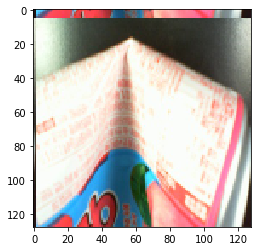

Reconstructed2:


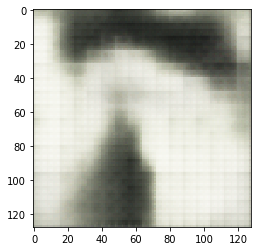

Epochs: 30/500
Train loss: 0.77131434
Train acc: 0.71819198
Valid loss: 2.57525408
Valid acc: 0.28515625
Original1:


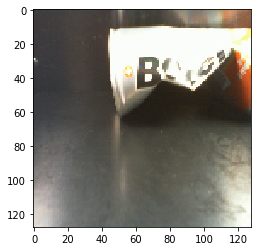

Reconstructed1:


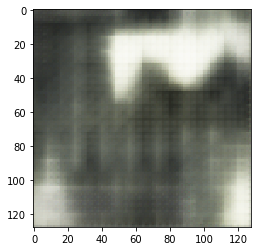

Original2:


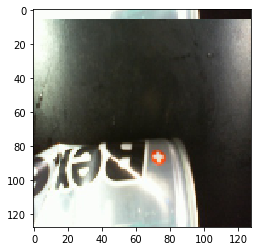

Reconstructed2:


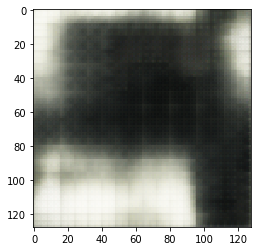

Epochs: 40/500
Train loss: 0.69047030
Train acc: 0.75223213
Valid loss: 2.83403635
Valid acc: 0.30859375
Original1:


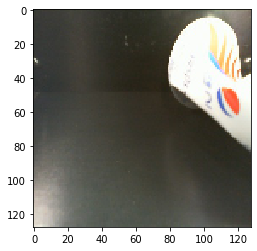

Reconstructed1:


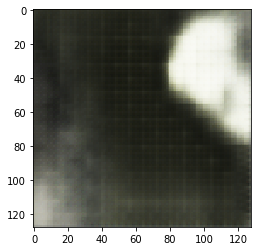

Original2:


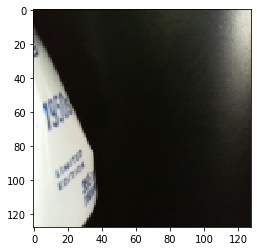

Reconstructed2:


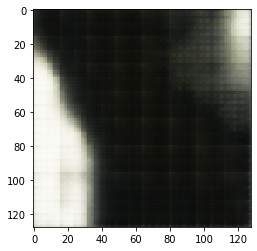

Epochs: 50/500
Train loss: 0.58406553
Train acc: 0.79910713
Valid loss: 2.84919918
Valid acc: 0.32421875


KeyboardInterrupt: 

In [5]:
for e in range(EPOCHS):
    
    train_loss = 0.0
    train_clf_acc = 0.0
    
    for x_batch_, y_batch_ in train_dloader.next_batch():
        x_batch_ = x_batch_.reshape(-1, IN_CHANNEL, HEIGHT, WIDTH)
        y_batch = np.repeat(y_batch_, 8, axis=0)
        y_batch = torch.LongTensor(y_batch).cuda()
        
        x_batch_noise = np.zeros_like(x_batch_)
        r = np.random.rand(x_batch_.shape[0])
        noise = np.random.randn(*x_batch_.shape) * 0.05
        x_batch_noise[r < 0.5] = x_batch_[r < 0.5] + noise[r < 0.5]
        x_batch_noise[r >= 0.5] = x_batch_[r >= 0.5]
        
        x_batch = torch.FloatTensor(x_batch_).cuda()
        x_batch_noise = torch.FloatTensor(x_batch_noise).cuda()
        
        reconstructed, latent = model(x_batch_noise)
        logps = model.classify(latent)
        
        with torch.no_grad():
            ps = torch.exp(logps)
            val_k, cls_k = ps.topk(1, dim=1)
            equal = cls_k == y_batch.view(*cls_k.size())
            train_clf_acc += torch.mean(equal.type(torch.FloatTensor))
        
        loss_ce = criterion(logps, y_batch)
        
        contractive_loss = model.contractive_loss()
        
        loss = torch.mean((x_batch - reconstructed)**2) + contractive_loss + loss_ce
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (e+1)%10 == 0:
        
        valid_loss = 0.0
        valid_clf_acc = 0.0
        
        with torch.no_grad():
            model.eval()
            
            for x_batch_, y_batch_ in valid_dloader.next_batch():
                x_batch_ = x_batch_.reshape(-1, IN_CHANNEL, HEIGHT, WIDTH)
                y_batch = np.repeat(y_batch_, 8, axis=0)
                x_batch = torch.FloatTensor(x_batch_).cuda()
                y_batch = torch.LongTensor(y_batch).cuda()

                reconstructed, latent = model(x_batch)
                logps = model.classify(latent)
                ps = torch.exp(logps)
                _, topk = ps.topk(1, dim=1)
                equal = topk == y_batch.view(*topk.size())
                valid_clf_acc += torch.mean(equal.type(torch.FloatTensor))
        
                loss_ce = criterion(logps, y_batch)

                contractive_loss = model.contractive_loss()

                loss = torch.mean((x_batch - reconstructed)**2) + contractive_loss + loss_ce
                valid_loss += loss.item()

            train_loss /= len(train_dloader)
            train_clf_acc /= len(train_dloader)
            valid_loss /= len(valid_dloader)
            valid_clf_acc /= len(valid_dloader)

            test_image1 = x_batch_[0, :3]
            test_image1 = (test_image1 + 1) * 128
            test_image1 = test_image1.astype(np.ubyte)
            test_image1 = np.transpose(test_image1, axes=[1, 2, 0])

            reconstructed_image1 = reconstructed.cpu().detach().numpy()[0, :3]
            reconstructed_image1 = (reconstructed_image1 + 1) * 128
            reconstructed_image1 = reconstructed_image1.astype(np.ubyte)
            reconstructed_image1 = np.transpose(reconstructed_image1, axes=[1, 2, 0])

            test_image2 = x_batch_[0, 3:]
            test_image2 = (test_image2 + 1) * 128
            test_image2 = test_image2.astype(np.ubyte)
            test_image2 = np.transpose(test_image2, axes=[1, 2, 0])

            reconstructed_image2 = reconstructed.cpu().detach().numpy()[0, 3:]
            reconstructed_image2 = (reconstructed_image2 + 1) * 128
            reconstructed_image2 = reconstructed_image2.astype(np.ubyte)
            reconstructed_image2 = np.transpose(reconstructed_image2, axes=[1, 2, 0])

            print("Original1:")
            plt.imshow(test_image1)
            plt.show()

            print("Reconstructed1:")
            plt.imshow(reconstructed_image1)
            plt.show()

            print("Original2:")
            plt.imshow(test_image2)
            plt.show()

            print("Reconstructed2:")
            plt.imshow(reconstructed_image2)
            plt.show()

            print(f"Epochs: {e+1}/{EPOCHS}")
            print(f"Train loss: {train_loss:.8f}")
            print(f"Train acc: {train_clf_acc:.8f}")
            print(f"Valid loss: {valid_loss:.8f}")
            print(f"Valid acc: {valid_clf_acc:.8f}")

            model.train()
        
model.save(AE_CKPT_PATH)